# How to Create an ARIMA Model for Time Series Forecasting in Python
A popular and widely used statistical method for time series forecasting is the ARIMA model.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

In this tutorial, you will discover how to develop an ARIMA model for time series data with Python.

After completing this tutorial, you will know:

- About the ARIMA model the parameters used and assumptions made by the model.
- How to fit an ARIMA model to data and use it to make forecasts.
- How to configure the ARIMA model on your time series problem.

### All credit to https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ for tutorial

# Autoregressive Integrated Moving Average Model
An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I:** Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA:** Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- **p:** The number of lag observations included in the model, also called the lag order.
- **d:** The number of times that the raw observations are differenced, also called the degree of differencing.
- **q:** The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

Next, let’s take a look at how we can use the ARIMA model in Python. We will start with loading a simple univariate time series.

In [16]:
import warnings
import itertools

import pandas as pd 

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('figure', figsize=(14, 8))

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/sales-of-shampoo-over-a-three-ye.csv', header = 0)

In [3]:
df.head()

,Month,Sales of shampoo over a three year period
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [4]:
df['Month'] = df['Month'].apply(lambda month: pd.datetime.strptime('190'+month, '%Y-%m'))

In [5]:
df.set_index('Month',inplace = True)

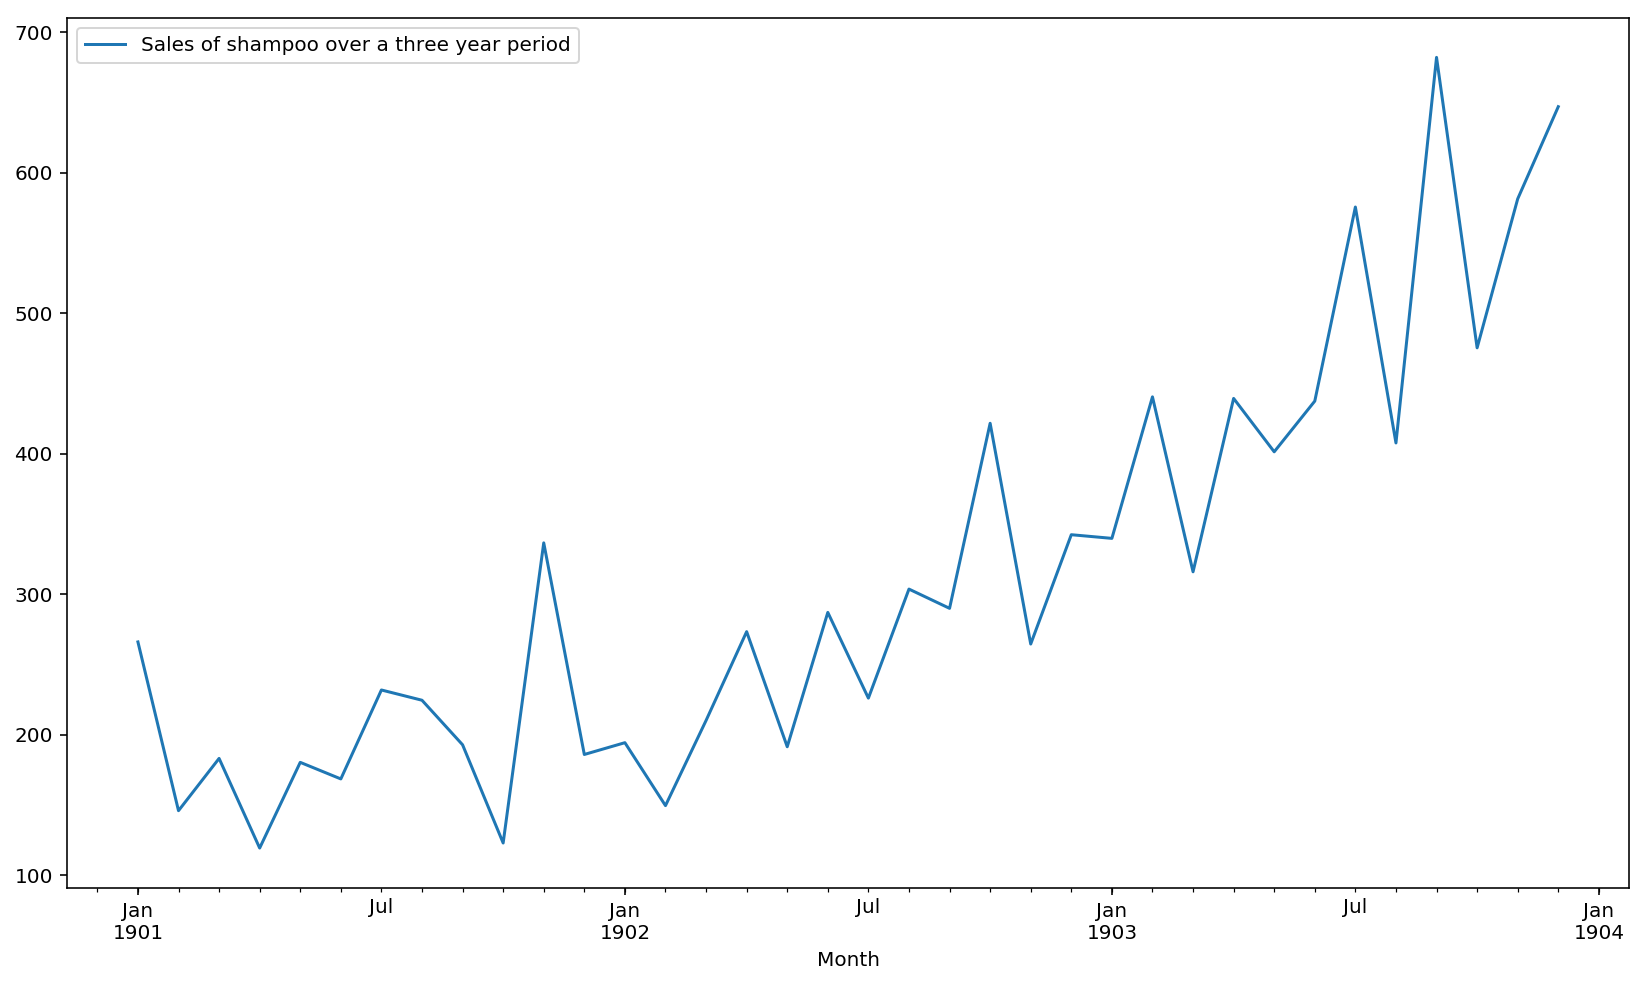

In [6]:
df.plot()
plt.show()

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

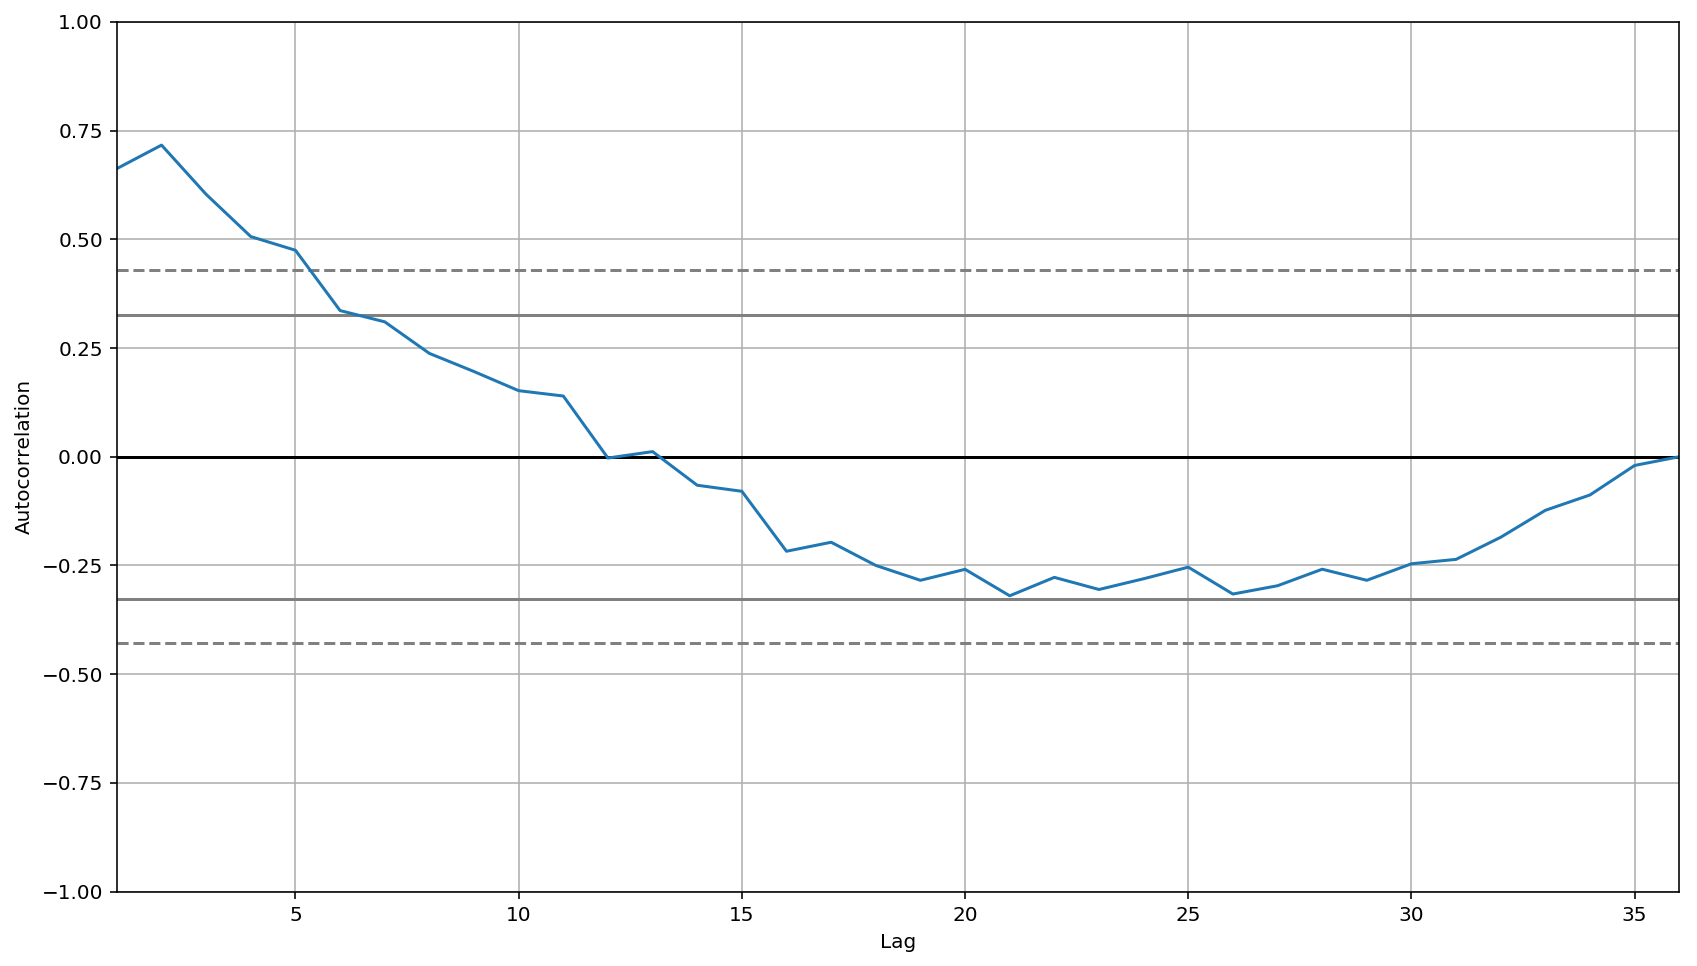

In [7]:
pd.plotting.autocorrelation_plot(df);

# ARIMA with Python
The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [8]:
# fit model 
model = ARIMA(df, order = (5,1,0))
model_fit = model.fit(disp = 0)

Running the example prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

In [9]:
print model_fit.summary()

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Sat, 29 Sep 2018   AIC                            406.340
Time:                                                 11:15:23   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

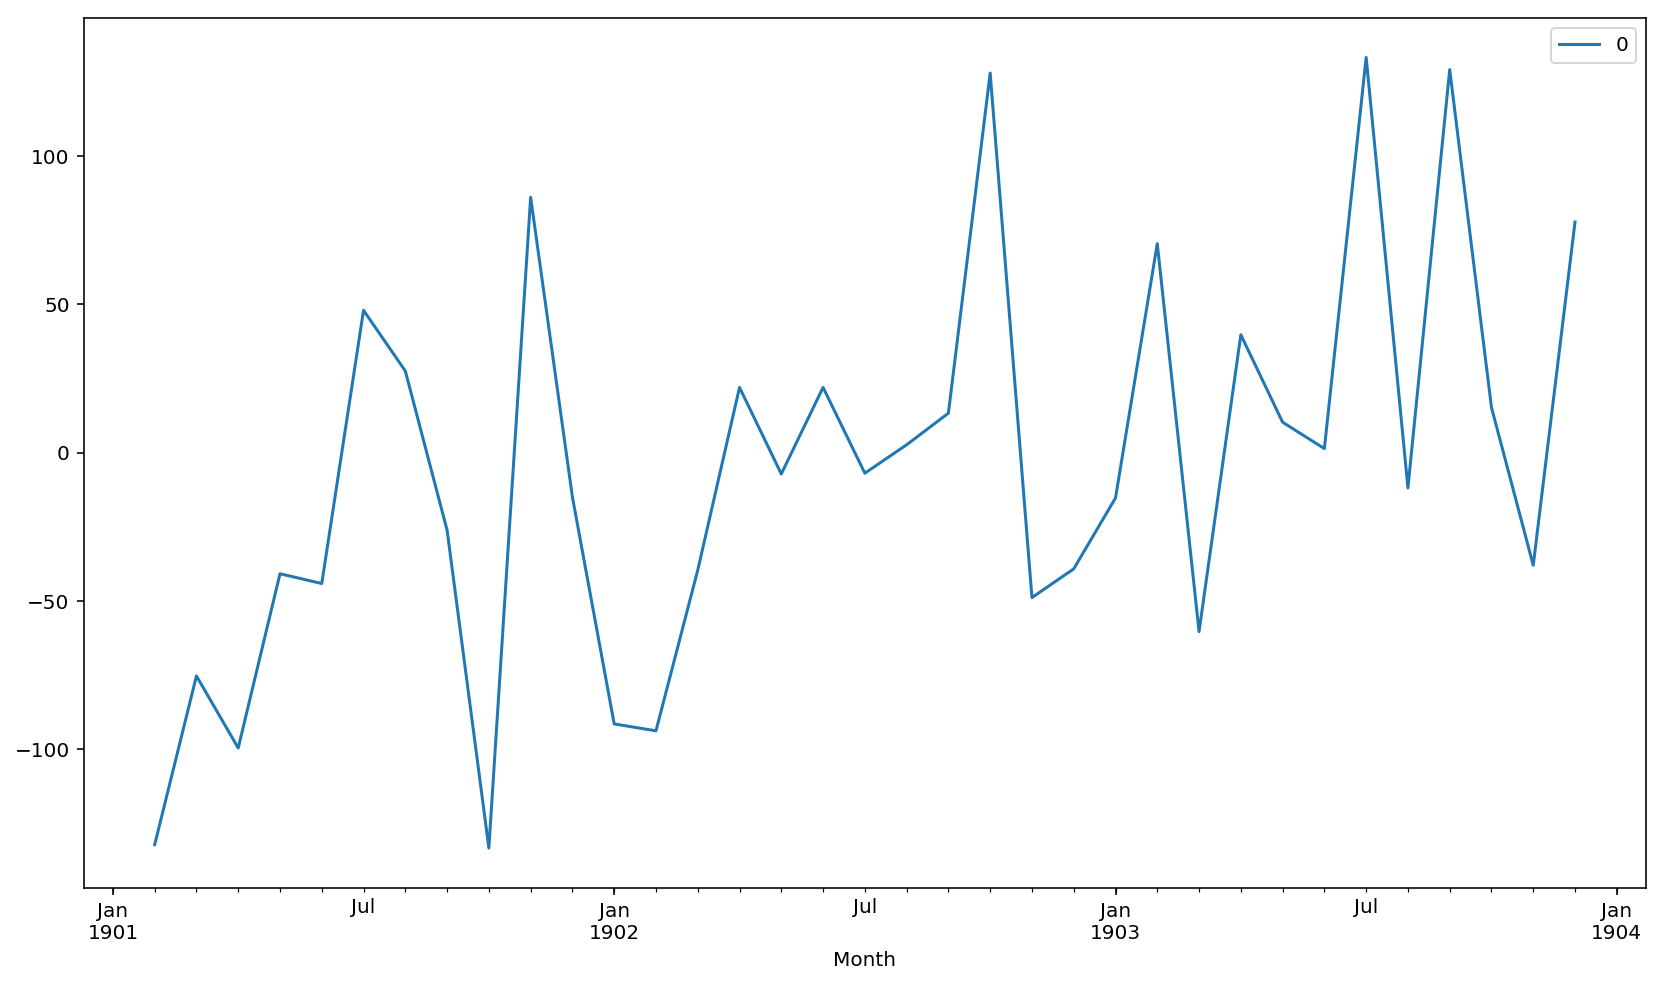

In [10]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot();

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

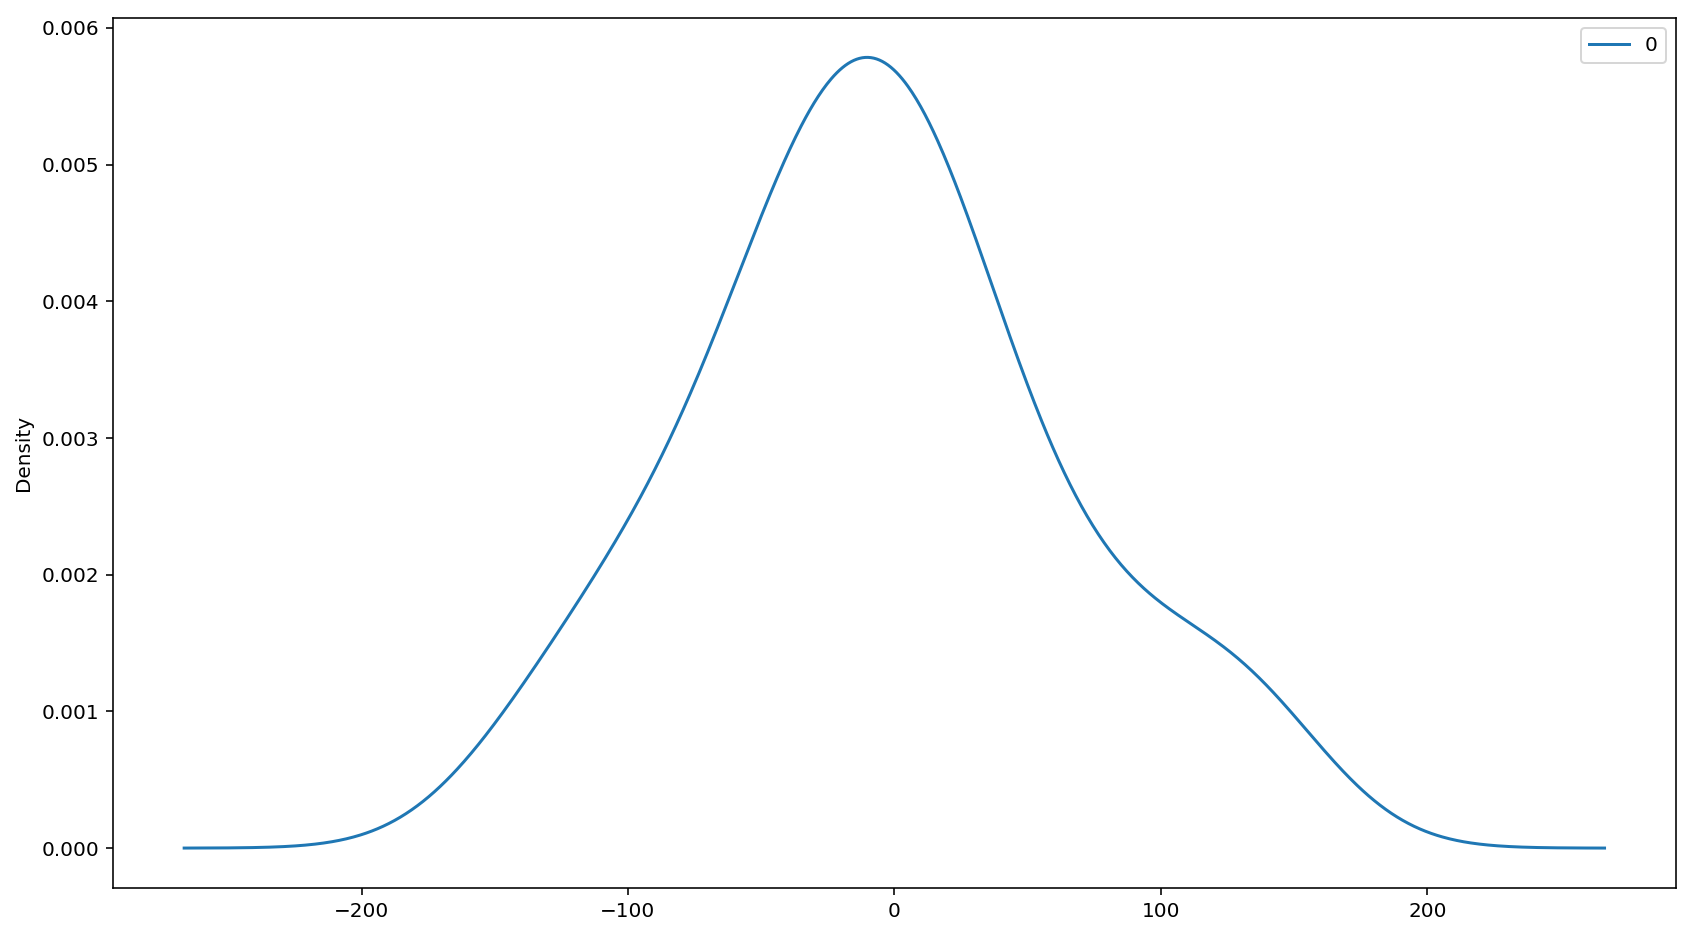

In [11]:
residuals.plot(kind='kde');

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [12]:
print residuals.describe()

                0
count   35.000000
mean    -5.495210
std     68.132882
min   -133.296612
25%    -42.477871
50%     -7.186559
75%     24.748341
max    133.237971


Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

Next, let’s look at how we can use the ARIMA model to make forecasts.

# Rolling Forecast ARIMA Model
The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

In [13]:
X = df.values
size = int(len(X) * 0.66)
train, test = X[0: size], X[size: len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)): 
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    observation = test[t]
    history.append(observation)
    print "prediction=%f, expected=%f" %(yhat, observation)
error = mean_squared_error(test, predictions)
print "Test MSE: %.3f" % error

prediction=349.117665, expected=342.300000
prediction=306.513011, expected=339.700000
prediction=387.376413, expected=440.400000
prediction=348.154135, expected=315.900000
prediction=386.308832, expected=439.300000
prediction=356.081997, expected=401.300000
prediction=446.379498, expected=437.400000
prediction=394.737285, expected=575.500000
prediction=434.915549, expected=407.600000
prediction=507.923450, expected=682.000000
prediction=435.482927, expected=475.300000
prediction=652.743831, expected=581.300000
prediction=546.343484, expected=646.900000
Test MSE: 6958.325


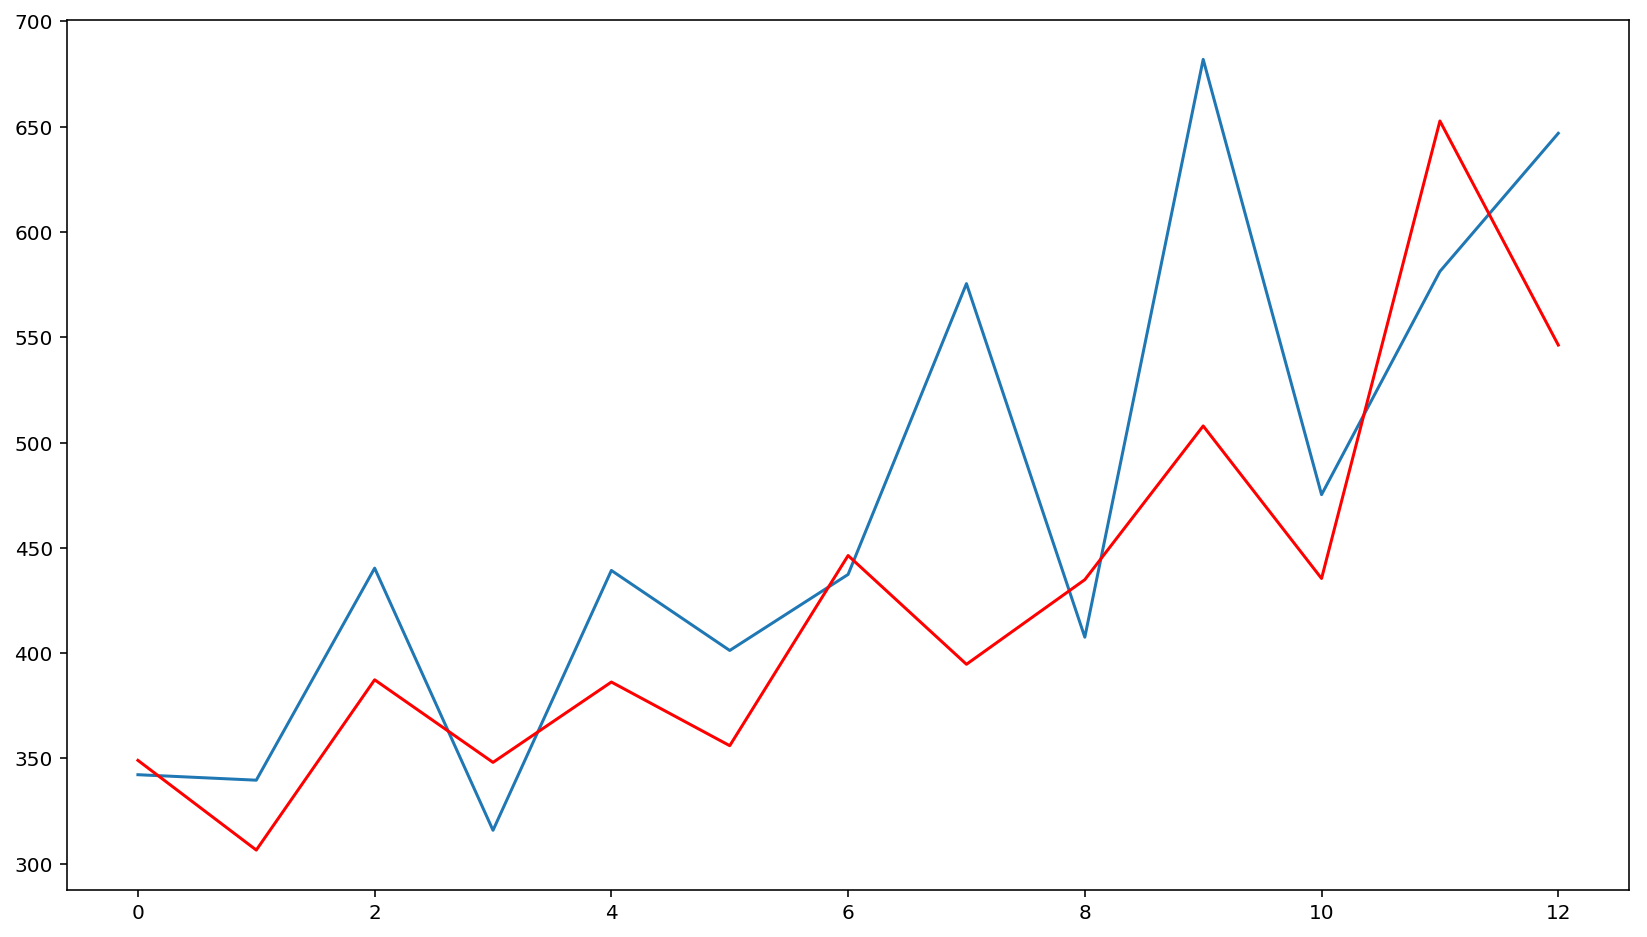

In [14]:
plt.plot(test)
plt.plot(predictions, color = 'red');

# Configuring an ARIMA Model
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

1. Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
2. Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
3. Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

The process was described in the classic 1970 textbook on the topic titled Time Series Analysis: Forecasting and Control by George Box and Gwilym Jenkins. An updated 5th edition is now available if you are interested in going deeper into this type of model and methodology.

Given that the model can be fit efficiently on modest-sized time series datasets, grid searching parameters of the model can be a valuable approach.

In [17]:
# Define the p, d, and q parameters to take any value between 0 and 5 
p = d = q = range(0,5)

# Generate all different combinations of p, d and q triplets 
pdq = list(itertools.product(p,d,q))

In [ ]:
# grid search to find optimal parameters for model 
X = df.values
size = int(len(X) * 0.66)
train, test = X[0: size], X[size: len(X)]
history = [x for x in train]
predictions = list()

for param in pdq: 
    try: 
        for t in range(len(test)): 
            model = ARIMA(history, order=param)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            observation = test[t]
            history.append(observation)
            # print "prediction=%f, expected=%f" %(yhat, observation)
        error = mean_squared_error(test, predictions)
        print "Test MSE: %.3f with ARIMA Model parameters: %s" % (error, param)
    except: 
        continue


Test MSE: 52425.268 with ARIMA Model parameters: (0, 0, 0)


# Summary
In this tutorial, you discovered how to develop an ARIMA model for time series forecasting in Python.

Specifically, you learned:

- About the ARIMA model, how it can be configured, and assumptions made by the model.
- How to perform a quick time series analysis using the ARIMA model.
- How to use an ARIMA model to forecast out of sample predictions.